# Example Notebook (run time ~ 15 minutes)

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sxs
import scri
import numpy as np
from scri.asymptotic_bondi_data.map_to_superrest_frame import MT_to_WM, WM_to_MT

from qnmfinder import utils
from qnmfinder import model
from qnmfinder import ringdown

import multiprocessing
from functools import partial

In [2]:
import matplotlib.pyplot as plt

## Load example NR data (note that this fits the news, not the strain)

In [3]:
simulation = 'example_data/SXS:BBH:2091'

In [4]:
h = MT_to_WM(WM_to_MT(sxs.load(f'{simulation}/ringdown_waveform.h5', drop_times_before="begin")))
metadata = sxs.Metadata.from_file(f'{simulation}/metadata.json')

total_mass = metadata['reference-mass1'] + metadata['reference-mass2']
h.t *= total_mass
h.data = h.data_dot

M_f = metadata['remnant-mass']
chi_f = np.linalg.norm(metadata['remnant-dimensionless-spin'])

In [5]:
M_f

0.951357381707

In [6]:
chi_f

0.685164922524

(-10.0, 200.0)

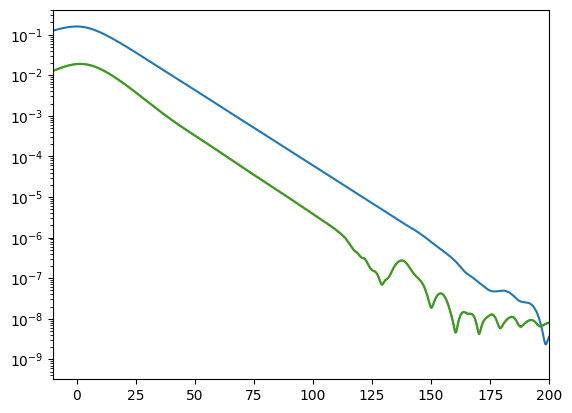

In [7]:
plt.plot(h.t, abs(h.data[:,h.index(2,2)]))
plt.plot(h.t, abs(h.data[:,h.index(4,4)]))
plt.plot(h.t, abs(h.data[:,h.index(4,-4)]))
plt.yscale('log')
plt.xlim(-10, 200)

## Analytic Example w/ Noise

Construct a `model.QNMModelBuilder` object

In [8]:
QNM_model_builder = model.QNMModelBuilder(
    h, M_f, chi_f,
    t_0_f=60, t_f=80, modes=[(2,2),(2,-2),(2,0),(4,4),(4,-4)],
    n_procs=-1, verbose=False
)

********
********


/Users/keefemitman/opt/anaconda3/lib/python3.9/site-packages/qnmfinder/utils.py:182: RuntimeWarning: invalid value encountered in scalar divide
  mismatch = 1 - h_1_h_2_overlap / np.sqrt(h_1_norm * h_2_norm)


Define a `ringdown.QNMModel` that we will use to replace the waveform data in `QNMModelBuilder`

In [9]:
QNM_model = ringdown.QNMModel(
    M_f,
    chi_f,
    [
        ringdown.QNM((2,2,0,1)),
        ringdown.QNM((2,2,0,-1)),
        ringdown.QNM((2,2,1,1)),
        ringdown.QNM((3,2,0,1)),
        ringdown.QNM((2,-2,0,-1)),
        ringdown.QNM((2,-2,0,1)),
        ringdown.QNM((2,-2,1,-1)),
        ringdown.QNM((3,-2,0,-1)),
        ringdown.QNM((2,0,0,1)),
        ringdown.QNM((2,0,0,-1)),
        ringdown.QNM((4,4,0,1)),
        ringdown.QNM((4,-4,0,-1)),
        ringdown.QNM([(2,2,0,1),(2,2,0,1)], (4,4)),
        ringdown.QNM([(2,-2,0,-1),(2,-2,0,-1)], (4,-4))
    ]
)

Fit the QNM model to the NR waveform to obtain some reasonable QNM amplitudes and constract a corresponding waveform with some noise

In [10]:
fit_QNM_model = QNM_model.fit(QNM_model_builder.h_NR, QNM_model_builder.modes, QNM_model_builder.t_0s[0])
for QNM in fit_QNM_model.QNMs:
    print(QNM.mode, QNM.A)
h_QNM = fit_QNM_model.compute_waveform(QNM_model_builder.h_NR)
h_QNM.data += np.random.normal(0, 1e-8, h_QNM.data.shape)

(2, 2, 0, 1) (0.24181424346013558-0.009965387863758076j)
(2, 2, 0, -1) (0.0013265383392881414+0.0008998279047045671j)
(2, 2, 1, 1) (-0.11966710179317634-0.07175868248698006j)
(3, 2, 0, 1) (-0.05428284563958508+0.03556824433084378j)
(2, -2, 0, -1) (0.24181424610481653+0.009965383463811858j)
(2, -2, 0, 1) (0.0013265383496609412-0.0008998279577700496j)
(2, -2, 1, -1) (-0.11966710232836882+0.07175868592564147j)
(3, -2, 0, -1) (0.05428284700564575+0.03556824376064607j)
(2, 0, 0, 1) (0.0009548724246344551+0.0037236315933592092j)
(2, 0, 0, -1) (0.000954872353054441-0.0037236315039473966j)
(4, 4, 0, 1) (-0.0252401636283635-0.009964281531534131j)
(4, -4, 0, -1) (-0.02524016390265618+0.009964282288698985j)
[(2, 2, 0, 1), (2, 2, 0, 1)] (0.03171167896216777+0.031659081420179334j)
[(2, -2, 0, -1), (2, -2, 0, -1)] (0.03171167893777781-0.03165908268604637j)


Use this analytic waveform as the waveform to build a model for and update the initial model to be empty

In [11]:
QNM_model_builder.h_NR = h_QNM
QNM_model_builder.update_model(ringdown.QNMModel(M_f, chi_f))

Build the model! (this can take a few minutes)

In [12]:
QNM_model_builder.build_model()

***************
Building Model!
***************

** new model is
- (2, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)
- (2, 2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)
- (2, 2, 0, -1)
- (2, -2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)
- (2, 2, 0, -1)
- (2, -2, 0, 1)
- (2, 2, 1, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (4, -4, 0, -1)
- (4, 4, 0, 1

Check to see if the model we built for the waveform matches the QNMs we used to construct the waveform

In [13]:
input_modes = [QNM.mode for QNM in fit_QNM_model.QNMs]
output_modes = [QNM.mode for QNM in QNM_model_builder.QNM_model.QNMs]

print_unequal_modes = False

passed = False
if utils.lists_are_equal(input_modes, output_modes):
    As_match = True
    for QNM1 in fit_QNM_model.QNMs:
        for QNM2 in QNM_model_builder.QNM_model.QNMs:
            if QNM1.mode == QNM2.mode:
                if not np.allclose(0., abs(QNM1.A - QNM2.A)):
                    As_match = False
    if As_match:
        passed = True
        print("Analytic test successful!")
    else:
        print("Mode finding successful! But amplitudes don't exactly match (expected if there is nonzero noise).")
        if print_unequal_modes:
            for QNM1 in fit_QNM_model.QNMs:
                for QNM2 in QNM_model_builder.QNM_model.QNMs:
                    if QNM1.mode == QNM2.mode:
                        if not np.allclose(0., abs(QNM1.A - QNM2.A)):
                            print(QNM1.mode)
                            print(QNM1.A)
                            print(QNM2.A)
                            print(abs(QNM1.A - QNM2.A))
                            
if not passed:
    for QNM in input_modes:
        if not QNM in output_modes:
            print(f"Failed to find {QNM}.")
    for QNM in output_modes:
        if not QNM in input_modes:
            print(f"Found spurious {QNM}.")

Mode finding successful! But amplitudes don't exactly match (expected if there is nonzero noise).


Finally, we can also plot the amplitudes and phases over their most stable windows

(Only shows the $m >= 0$ modes, since the example simulation is non-precessing)

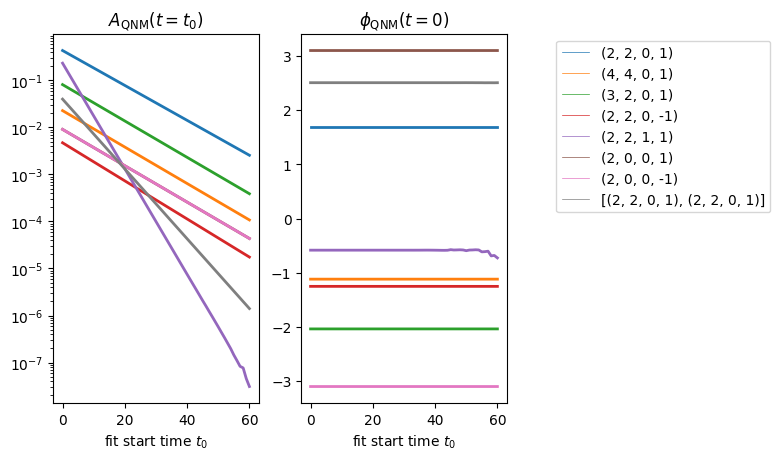

In [14]:
fig, axis = plt.subplots(1, 3, width_ratios=[1, 1, 0])
plt.subplots_adjust(wspace=0.31)

for QNM in QNM_model_builder.QNM_model.QNMs:
    if QNM.target_mode[1] < 0:
        continue
    p = axis[0].plot(
        QNM_model_builder.t_0s,
        abs(QNM.A_time_series / (-1j * QNM.omega) * np.exp(-1j*QNM.omega*QNM_model_builder.t_0s)),
        lw=0.5
    )
    idx1 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[0]))
    idx2 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[1])) + 1
    axis[0].plot(
        QNM_model_builder.t_0s[idx1:idx2],
        abs(QNM.A_time_series / (-1j * QNM.omega) * np.exp(-1j*QNM.omega*QNM_model_builder.t_0s))[idx1:idx2],
        lw=2,
        color=p[0].get_color()
    )
    
    p = axis[1].plot(
        QNM_model_builder.t_0s,
        np.angle(QNM.A_time_series / (-1j * QNM.omega)),
        lw=0.5
    )
    idx1 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[0]))
    idx2 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[1])) + 1
    axis[1].plot(
        QNM_model_builder.t_0s[idx1:idx2],
        np.angle(QNM.A_time_series / (-1j * QNM.omega))[idx1:idx2],
        lw=2,
        color=p[0].get_color()
    )
    
    axis[2].plot(
        [None],
        [None],
        lw=0.5,
        label=str(QNM.mode)
    )
axis[0].set_yscale('log')
axis[2].legend(loc='upper left')

axis[2].spines['top'].set_visible(False)
axis[2].spines['right'].set_visible(False)
axis[2].spines['bottom'].set_visible(False)
axis[2].spines['left'].set_visible(False)
axis[2].get_xaxis().set_ticks([])
axis[2].get_yaxis().set_ticks([])

axis[0].set_xlabel('fit start time $t_{0}$')
axis[1].set_xlabel('fit start time $t_{0}$')
axis[0].set_title('$A_{\mathrm{QNM}}(t=t_{0})$')
axis[1].set_title('$\phi_{\mathrm{QNM}}(t=0)$');

## Analyze a NR waveform corresponding to SXS:BBH:2091

Construct a `model.QNMModelBuilder` object

In [15]:
QNM_model_builder = model.QNMModelBuilder(
    h, M_f, chi_f, t_i=0, t_0_f=60,  d_t_0=1.0, t_f=80,
    CV_tolerance=2e-2,
    n_procs=-1, verbose=False
)

Build the model! (this can take a $\mathcal{O}(10)$ minutes)

In [16]:
QNM_model_builder.build_model()

***************
Building Model!
***************

** new model is
- (2, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)
- (3, -3, 0, -1)

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -

** new model is
- (2, -2, 0, -1)
- (2, 2, 0, 1)
- (2, 1, 0, 1)
- (2, -1, 0, -1)
- (4, -4, 0, -1)
- (4, 4, 0, 1)
- (3, 2, 0, 1)
- (3, -2, 0, -1)
- (3, -3, 0, -1)
- (3, 3, 0, 1)
- (2, 0, 0, 1)
- (2, 0, 0, -1)
- (5, -5, 0, -1)
- (5, 5, 0, 1)
- (4, 3, 0, 1)
- (4, -3, 0, -1)
- (2, 2, 1, 1)
- (2, -2, 1, -1)
- (5, 4, 0, 1)
- (5, -4, 0, -1)
- (3, 1, 0, 1)
- (3, -1, 0, -1)
- (4, 2, 0, 1)
- (4, -2, 0, -1)
- [(2, -2, 0, -1), (2, -2, 0, -1)]
- [(2, 2, 0, 1), (2, 2, 0, 1)]



Check the mismatch over times in the window [0,60]

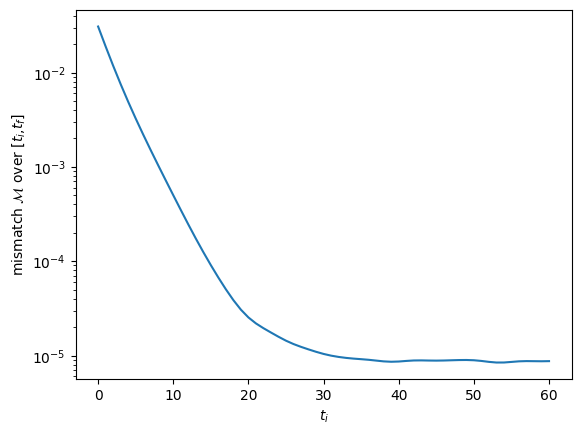

In [17]:
fig, axis = plt.subplots(1, 1)
axis.plot(QNM_model_builder.t_0s, QNM_model_builder.mismatches)
axis.set_yscale('log')
axis.set_xlabel('$t_{i}$')
axis.set_ylabel('mismatch $\mathcal{M}$ over [$t_{i}$,$t_{f}$]');

Plot the amplitudes and phases over their most stable windows

(Only shows the $m >= 0$ modes, since the example simulation is non-precessing)

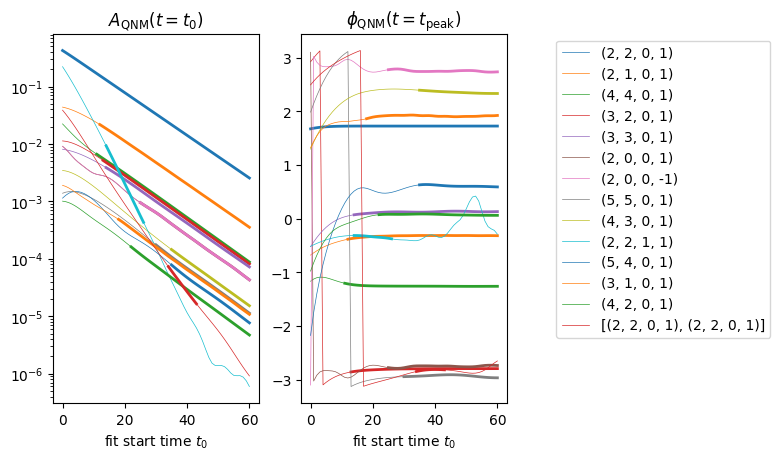

In [18]:
fig, axis = plt.subplots(1, 3, width_ratios=[1, 1, 0])
plt.subplots_adjust(wspace=0.31)

for QNM in QNM_model_builder.QNM_model.QNMs:
    if QNM.target_mode[1] < 0:
        continue
    p = axis[0].plot(
        QNM_model_builder.t_0s,
        abs(QNM.A_time_series / (-1j * QNM.omega) * np.exp(-1j*QNM.omega*QNM_model_builder.t_0s)),
        lw=0.5
    )
    idx1 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[0]))
    idx2 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[1])) + 1
    axis[0].plot(
        QNM_model_builder.t_0s[idx1:idx2],
        abs(QNM.A_time_series / (-1j * QNM.omega) * np.exp(-1j*QNM.omega*QNM_model_builder.t_0s))[idx1:idx2],
        lw=2,
        color=p[0].get_color()
    )
    
    p = axis[1].plot(
        QNM_model_builder.t_0s,
        np.angle(QNM.A_time_series / (-1j * QNM.omega)),
        lw=0.5
    )
    idx1 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[0]))
    idx2 = np.argmin(abs(QNM_model_builder.t_0s - QNM.largest_stable_window[1])) + 1
    axis[1].plot(
        QNM_model_builder.t_0s[idx1:idx2],
        np.angle(QNM.A_time_series / (-1j * QNM.omega))[idx1:idx2],
        lw=2,
        color=p[0].get_color()
    )
    
    axis[2].plot(
        [None],
        [None],
        lw=0.5,
        label=str(QNM.mode)
    )
axis[0].set_yscale('log')
axis[2].legend(loc='upper left')

axis[2].spines['top'].set_visible(False)
axis[2].spines['right'].set_visible(False)
axis[2].spines['bottom'].set_visible(False)
axis[2].spines['left'].set_visible(False)
axis[2].get_xaxis().set_ticks([])
axis[2].get_yaxis().set_ticks([])

axis[0].set_xlabel('fit start time $t_{0}$')
axis[1].set_xlabel('fit start time $t_{0}$')
axis[0].set_title('$A_{\mathrm{QNM}}(t=t_{0})$')
axis[1].set_title('$\phi_{\mathrm{QNM}}(t=t_{\mathrm{peak}})$');